In [53]:
!pip install nltk
!pip install scikit-network
!pip install numpy

In [54]:
from nltk import stem
import numpy as np
from operator import itemgetter

## Download and extract the data

From [here](https://snap.stanford.edu/data/bigdata/memetracker9/quotes_2008-08.txt.gz). Extract it on your computer (or alternatively upload it to Google Colab).

## Parsing the Memetracker data

Each line of the data is structured as a tuple (MARKER, TEXT), where the first letter of the line encodes:

- P: URL of the document
- T: time of the post (timestamp)
- Q: phrase extracted from the text of the document
- L: hyper-links in the document (links pointing to other documents on the web)

Note some documents have zero phrases or zero links. 

In [55]:
L = 4 # minimum sentence length
M = 20 # minimum frequency threshold
FILEPATH = "C:/Users/alexa/Downloads/Creneau D/Computer social sciences/TP2_memetracker/quotes_2008-08.txt"  # PUT YOUR FILE PATH HERE

In [56]:
f = open(FILEPATH, "r", encoding="utf-8")
quotes = {}
MAX_LINES = 1000000
i= 0

for line in f:
    if i > MAX_LINES:
        break
    
    contents = line.strip().split("\t")
    
    if line == "\n":
        domain = None
        ts = None
    else:
        marker = contents[0]
        text = contents[1]
    
        if marker == "P":
            domain = text
        elif marker == "T":
            ts = text
        elif marker == "Q":
            splitted_text = text.split(" ")
            if len(splitted_text) >= L:
                
                if text in quotes:
                    quotes[text]["domains"].append(domain)
                    quotes[text]["timestamps"].append(ts)
                else:
                    quotes[text] = {"domains": [domain], "timestamps": [ts]}
                    
    i += 1

Choose a sentence (the fist one, for example) and display its domain names and timestamps in order to get familiar with the data structure.

In [57]:


first_quote = list(quotes)[0] 
domains = quotes[first_quote]["domains"]
timestamps = quotes[first_quote]["timestamps"]

print("First quote : " + first_quote)
print("Domain names : ", end='')
print(domains)
print("Timestamps : " , end='')
print(timestamps)


First quote : how to create property binding in a visual webgui silverlight control
Domain names : ['http://codeproject.com/kb/silverlight/convertsilverlightcontrol.aspx']
Timestamps : ['2008-08-01 00:00:00']


How many sentences does the dataset contain?

In [58]:
print("There are : " + str(len(quotes)) + ' different sentences')
totsentences=0
for text in quotes:
    totsentences+=len(quotes[text]['domains'])
print("There are : " + str(totsentences) + " sentences in total")

There are : 150572 different sentences
There are : 235464 sentences in total


Let us clean the data to only keep sentences that appear at least $M$ times.

In [ ]:

M=12
curated_data = []
for x in quotes:
    if len(quotes[x]["domains"]) > M:
        curated_data.append(x)
print(len(curated_data)) #M=20 donc on prend que les phrases qui apparaissent strictement plus de 12 fois

1266


## Building the sentence graph

Our goal is to build a directed graph, where each node $i$ is a sentence fragment observed in the data; there exists an edge between two nodes $i$ and $j$ if $i$ is included in $j$.


In [ ]:
def inclusion(i, j, edit_distance=1):
    stemmer = stem.PorterStemmer()
    L=[]
    M=[]
    word=''
    distance=0

    #Construction des phrases sous forme de liste contenant les mots de la phrase sous forme stem (racine des mots)
    for ch in i:
        if ch==' ':
            L.append(stemmer.stem(word))
            word=''
        else:
            word+=ch
    if word !='':
        L.append(stemmer.stem(word)) #ajout du dernier mot de la phrase si non vide
    word=''
    for ch in j:
        if ch==' ':
            M.append(stemmer.stem(word))
            word=''
        else:
            word+=ch
    if word !='':
        M.append(stemmer.stem(word))
    
    
    #Calcul de la distance de Levenshtein entre les deux phrases
    distance_initial=0
    for i in range(min(edit_distance,len(L))): #on supprime le début de L pour être sûr qu'il est dans M
        if L[0] not in M:
            del L[0]
            distance_initial+=1
    if L==[]:
        return True #si L est vide, alors il est inclus dans M
    
    debuts=[] 
    for i in range(len(M)):
        if L[0]==M[i]:
            debuts.append(i)
    
    if debuts==[]:
        return False
    #on considère tout les débuts potentielles de similarité dans M (il peut y avoir 2 fois le mot qui commence L dans M)
    M1=M.copy()
    L1=L.copy()
    for debut in debuts:
        M=M1.copy()
        L=L1.copy()
        M=M[debut:min(debut+len(L)+edit_distance , len(M))] #on enlève les mots de M qui ne peuvent pas être dans L pour satisfaire une distance minimal de edit_distance

        #on supprime les mots de L qui ne sont pas dans M (en augmentant la distance)
        distL=0
        for j in range(len(L)):
            if L[j-distL] not in M:
                del L[j-distL]
                distL+=1
        distM=0

        M=M[0:len(L)+edit_distance-distL] #on enlève les mots en trop de M

        #on supprime les mots de M qui ne sont pas dans L (en augmentant la distance)
        for j in range(len(M)):
            if M[j-distM] not in L:
                del M[j-distM]
                distM+=1

        distance=distL+distM+distance_initial
        if M==L and distance<=edit_distance: #on verifie l'égalité pour verifier que l'ordre des mots est le bon et que l'egalité tiens compte de la distance
            return True
    return False



i="this is really great"
j="this is great news for anyone interested in bats"
print(inclusion(i,j))
print(inclusion(i+" eating",j))

#renvoie les bonnes choses


#Le problème encore actuel de l'algo est si L[0] n'est pas dans M, ce qui est possible  (Corrigé)
# i="she is great"
# j="this is great news for anyone interested in bats"
# print(inclusion(i,j)) #cela devrait retourner True (i est inclue dans j à u) mais retourne False (Corrigé)


# Write a function that returns true if i is included in j, false otherwise
# variation : The function returns true if i is included in j to 1 word difference (ie. "this is really great" is then included in "this is great news for anyone interested in bats"
# if you wish to, you can gain in generality by using a stemmer: for a given word, stemmer.stem(word) will output its root, ie. stemmer.stem("eating") returns "eat".
    

True
False


Build a list `list_edges` of tuples $(i,j,w)$, each tuple meaning that sentences i et j are connected (use the inclusion function you write), and that they appear $w$ times. The next notebook cells will use this list to build the sentence graph. You can store the nodes (the sentence fragments) in the dictionary `nodes`.

In [ ]:
#Très long selon la valeur de M ie le nombre de phrases à comparer ; ici pour M=12, cela prend environ 6 minutes
cpt_nodes = 0
nodes = {}
edges = {}
labels = [ "a" for i in range(len(curated_data))]

for ind_i, i in enumerate(curated_data):
    for ind_j, j in enumerate(curated_data):
        if i == j:
            continue
        
        if len(i) < len(j):
            if inclusion(i, j):
                i1=i.split(" ")
                j1=j.split(" ")
                if not tuple(i1) in nodes:
                    nodes[tuple(i1)] = cpt_nodes
                    cpt_nodes += 1
                if not tuple(j1) in nodes:
                    nodes[tuple(j1)] = cpt_nodes
                    cpt_nodes += 1

                
                e = (nodes[tuple(i1)], nodes[tuple(j1)])
                if e in edges:
                    edges[e] += 1
                else:
                    edges[e] = 1
list_edges = [ (i[0], i[1], edges[i]) for i in edges ]
len(list_edges)

70

In [92]:
import sknetwork as skn
from IPython.display import SVG

In [93]:
g = skn.data.from_edge_list(list_edges, directed=True, weighted=True)
n = g.shape[0]
names = [ " ".join(x) for x in nodes.keys() ]
n

90

If your graph is not too large, you can even visualize it! :)

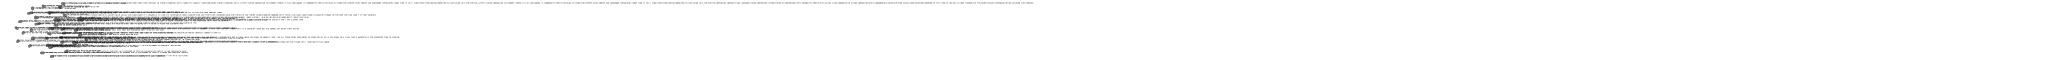

In [94]:
SVG(skn.visualization.svg_graph(g, names=names))

## Partition the graph

We now have an inclusion graph and a set of sentence fragments of our data, but still no sentence _clusters_. We know our graph is directed and acyclic: there are "sinks", nodes with no outgoing edge. These sinks correspond to sentence fragments for which a whole family of fragments is included.

We expect our sentence clusters to each contain one sink. Our method is as follows :
- Each sink (= node with out-degree $0$) will be in its own cluster,
- For each ndoe $v$ connected to a sink $u$, $C(v) = C(u)$,
- For each node $x$ not connected to a sink, we randomly assign it to a neighbouring cluster..

This is equivalent to assigning nodes to clusters by performing a breadth first search on the transposed graph.

Let us first identify sinks, using the function `get_degrees` of our library.

In [95]:
skn.utils.get_degrees(g)
sinks = np.where(skn.utils.get_degrees(g) == 0)[0]
len(sinks)

45

We now have the sinks. We can, for each sink and its neighbours, assign it an integer corresponding to its cluster (each if the $k$ sinks will have a different integer, between $0$ and $k-1$). Then, we know the neighbours of a sink are part of the same cluster. Once we have assigned sinks' neighbours, they know have a cluster identifier, so we can assign their neighbours, and so on. This way of exploring the graph is called a **Breadth-First Search** (BFS).

In [98]:
from collections import deque
import random
# implement here the graph partitioning

#On a un problème si par exemple un noeud est connecté à 2 puits differents, on considerera qu'il sera dans le cluster du premier puits trouvé

n=g.shape[0]
clusters={}
for i in range(len(sinks)):
    clusters[int(sinks[i])]=i

for i in range(n):
    if i not in clusters:
        
        if g.indptr[i+1]==g.indptr[i]:
            clusters[i]=None

        for j in g.indices[g.indptr[i]:g.indptr[i+1]]:
            if j in sinks:
                clusters[i]=clusters[j]
            break

while len(clusters)<n:
    for i in range(n):
        if i not in clusters:
            L=[]
            for j in g.indices[g.indptr[i]:g.indptr[i+1]]:
                if j in clusters:
                    L.append(clusters[j])
            clusters[i]=L[random.randint(0,len(L)-1)]

# print(g.indices)
# print(g.indptr)
# print(g.data)


We can visualise the graph again, coloring nodes by their respective cluster.

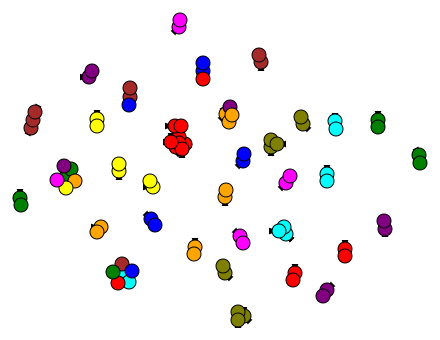

In [99]:
SVG(skn.visualization.svg_graph(g, labels=clusters))

## Identify _threads_ over time


In [101]:
from operator import itemgetter



threads = {}
for x in range(len(clusters)):
    c_x = clusters[x]
    
    if c_x in threads:
        threads[c_x]["domains"].extend(quotes[names[x]]["domains"])
        threads[c_x]["timestamps"].extend(quotes[names[x]]["timestamps"])
    else:
        threads[c_x] = {"domains": quotes[names[x]]["domains"], "timestamps": quotes[names[x]]["timestamps"]}
sorted([ (x, len(threads[x]["domains"]), len(threads[x]["timestamps"])) for x in threads ], key=itemgetter(1), reverse=True)[:5]

[(1, 1165, 1165), (38, 946, 946), (14, 876, 876), (7, 592, 592), (8, 348, 348)]

Display the sentences associated with the most frequent thread.

In [102]:

max_thread = max(threads, key=lambda x: len(threads[x]["domains"]))  # Le thread avec le plus de domaines

print("Les phrases associées au thread le plus fréquent sont :")
for x in range(len(clusters)):
    if clusters[x] == max_thread:  
        print(' - '+ names[x]) 

Les phrases associées au thread le plus fréquent sont :
 - playing the race card
 - barack obama has played the race card and he played it from the bottom of the deck it's divisive negative shameful and wrong
 - barack obama has played the race card and he played it from the bottom of the deck
 - played the race card and he played it from the bottom of the deck
 - divisive negative shameful and wrong
 - it's divisive negative shameful and wrong
 - played the race card
 - from the bottom of the deck


Display the frequent domain names associated with most frequent fragments.

In [103]:
domain_counts = {}
for domain in threads[max_thread]['domains']:
    if domain in domain_counts:
        domain_counts[domain] += 1
    else:
        domain_counts[domain] = 1


sorted_domains = sorted(domain_counts.items(), key=lambda x: x[1], reverse=True)

print("Les domaines les plus fréquents pour le fragments le plus frequent sont :")
for domain, count in sorted_domains[:3]:
    print(' - ' + domain + ' Count : ' + str(count))


Les domaines les plus fréquents pour le fragments le plus frequent sont :
 - http://blog.washingtonpost.com/the-trail/2008/07/31/mccain_camp_obama_has_played_t.html?nav=rss_email/components Count : 38
 - http://news.originalsignal.com/article/923825/the-caucus-mccain-camp-says-obama-is-playing-the-race-card.html Count : 26
 - http://blogrunner.com/snapshot/d/1/2/mccain_camp_obama_has_played_the_race_card Count : 24


## Algorithmic complexity

Give an estimation of the algorithmic complexity (time and space) of the method. If you have time, you can offer a parametrised version (by $L$ and $M$) !

En temps : 

Les algos sont à peu près tous en O(n) où n le nombre de phrase prises en compte, cependant il y en a 2 plus longs, celui sur la propagation des cluster qui peut être jusqu'en O((k/2)^2) dans le pire des cas (si le graphe est complet, avec k le nombre de sommet), ce qui n'est presque jamais les cas, donc ce n'est pas un problème. La pire complexité reste l'algorithme qui crée le graphe, l'algo s'effectue en O(n^2 * l) avec n le nombre de phrase après filtration et l le nombre max de lettre par phrase (on parcours toutes les lettres de chaque phrase pour construire les listes de mots), c'est cette partie du programme qui est longue à éxecuter et oblige l'utilisation de 'peu' de data.

En espace : 

La complexité en espace est maximum durant le même algo que pour le temps,de la même manière la complexité spatial est en O(n^2 * m) où n le nombre de phrase après filtration et m le nombre de mot max par phrase.